In [67]:
from src.statespace import RWModel, CVModel, CAModel, StateSpace
from src.trajectory import Trajectory
from src.kalmanfilter import KalmanFilter
from src.auxil import rmse, plot_estimates, plot_rmse, plot_traj
from src.kfnet import KFNet

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# sns.set()
sns.set_style("white")
# plt.style.use('seaborn-poster')

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
RANDOM_SEED = None
ndat = 200
q = 9.5e-5          # Process noise intensity
r = 1.3             # Observation noise std
c_rwm = 10          # RWM process noise scaling constant
expf = 0.95         # Exponential forgetting param
reset_thresh = 5.0  # Filter reset threshold (Euclidean distance from centroid)
init_state = np.zeros(6)

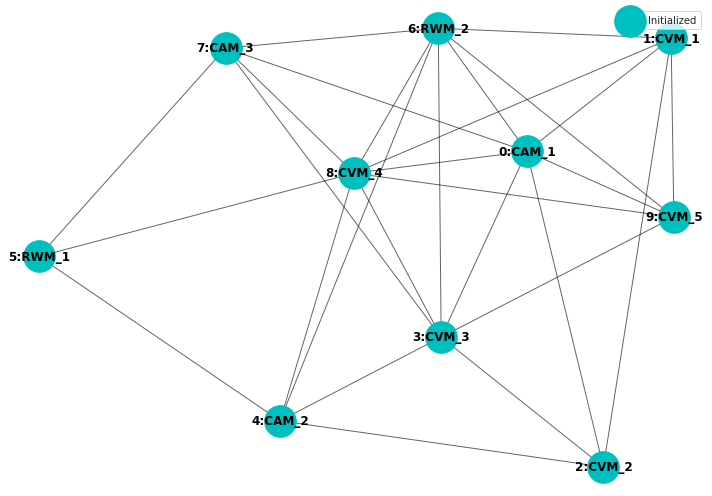

In [70]:
KFN_SEED = 5

kfs = [
    KalmanFilter(RWModel(c_rwm*q, r), lambda_expf=expf),
    KalmanFilter(RWModel(c_rwm*q, r), lambda_expf=expf),    
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CAModel(q, r)),
    KalmanFilter(CAModel(q, r)),
    KalmanFilter(CAModel(q, r)),
]
np.random.seed(KFN_SEED)
np.random.shuffle(kfs)
# lbls = ["RWM", "CVM", "CAM"]
# lbls = {n:lbl for n, lbl  in enumerate(lbls)}

kfn = KFNet(10, 7, init=kfs, random_seed=KFN_SEED)
np.random.seed()
kfn.generate_txt_labels()
kfn.draw_network()

In [71]:
# Trajectory simulator initialization
R = kfn.observation_covs()

traj = Trajectory(
            CAModel(q, r),
            n_steps=ndat,
            init_state=init_state,
            R=R,
            random_seed=None
)

In [72]:
for yt in traj.observations:
    kfn.time_step(
        yt,
        predict=True,
        update=True,
        adapt=True,
        combine=True,
        reset_strategy="mean",
        reset_thresh=reset_thresh,
        c=1.0
    )

In [73]:
RWM = kfn[6]
CVM = kfn[3]
CAM = kfn[7]

In [74]:
kfcam = KalmanFilter(CAModel(q, r))

for yt in traj.observations[:, 0]:
    kfcam.predict()
    kfcam.update(yt, log=True)

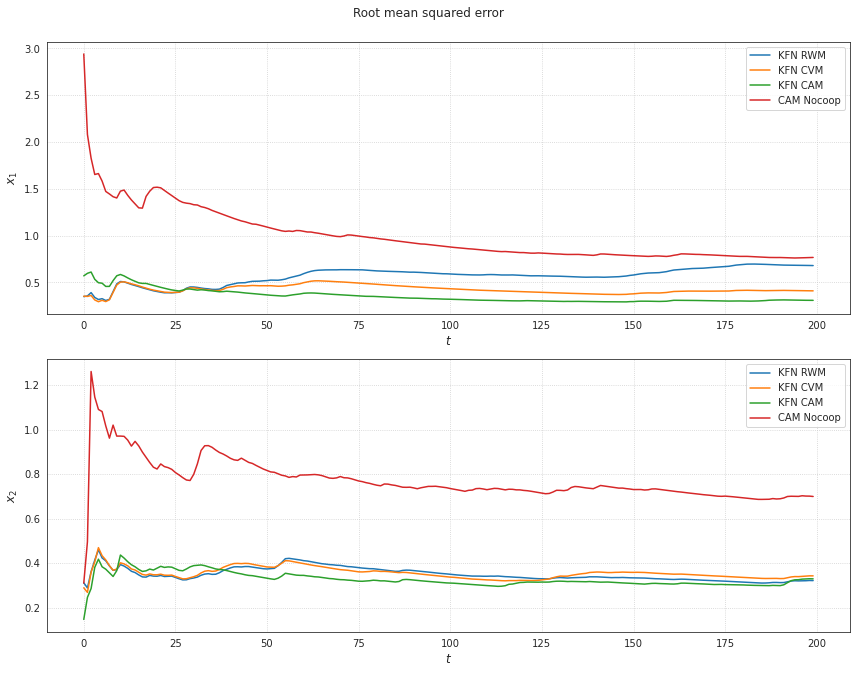

In [75]:
plot_rmse(traj, RWM, CVM, CAM, kfcam, nvars=2, var_labels=["$x_1$", "$x_2$"], kf_labels=["KFN RWM", "KFN CVM", "KFN CAM", "CAM Nocoop"])

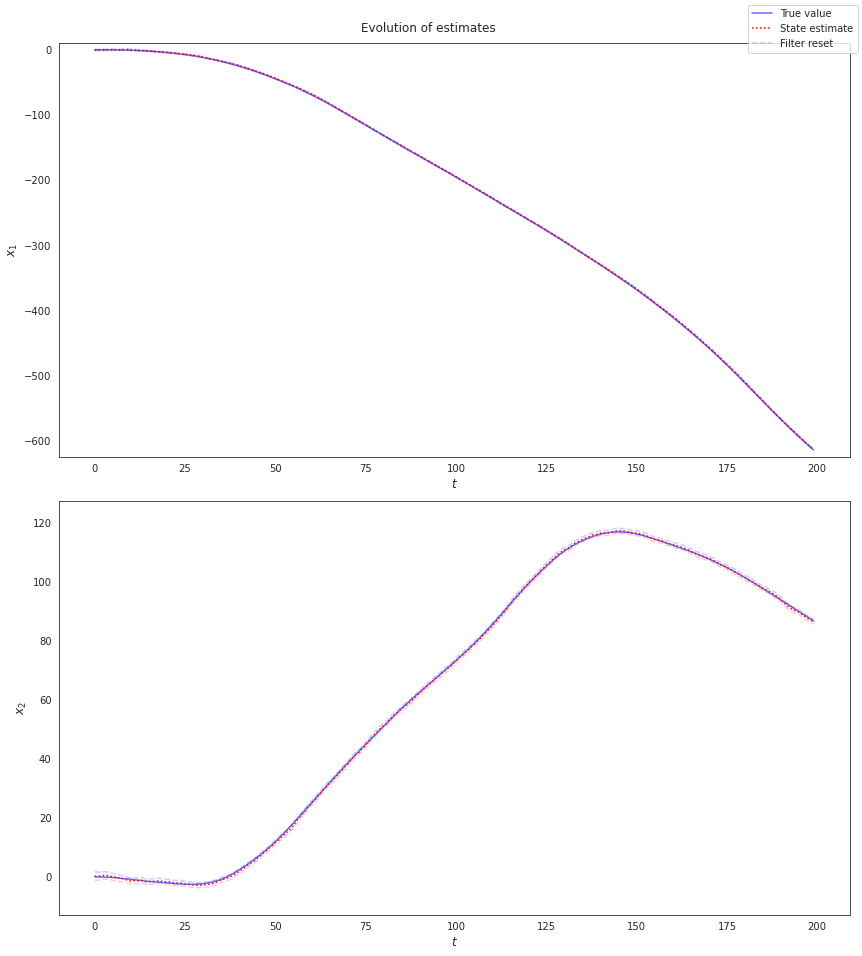

In [76]:
plot_estimates(RWM, traj, nvars=2, plt_std=True, labels=["$x_1$", "$x_2$"])

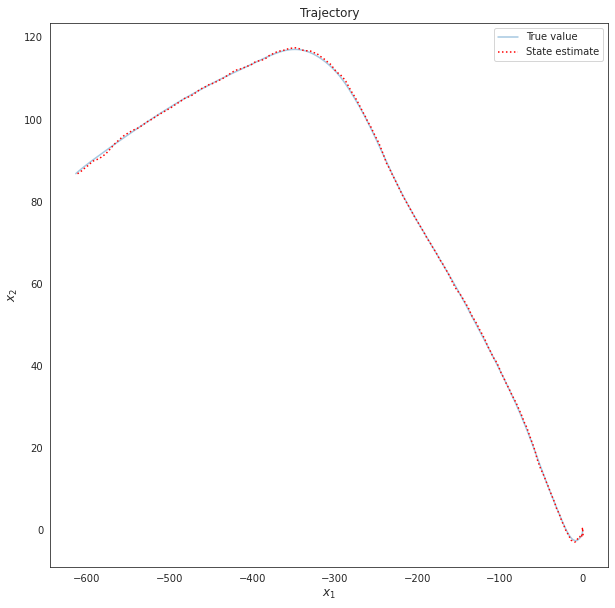

In [77]:
plot_traj(traj, kf=RWM)